# Лабораторная работа №5

## по курсу "Численные методы"

## Попов Матвей, М8О-408Б-20

## Вариант 1


In [10]:
x_begin = 0
x_end = 1.05

y_begin = 0
y_end = 1.05

h_x = 0.05
h_y = 0.05

def phi_0(y):
    return y

def phi_1(y):
    return 1 + y

def psi_0(x):
    return x

def psi_1(x):
    return 1 + x

def solution(x, y):
    return x + y


Запустим программу для вычислений

In [11]:
!go run cmd/main.go

Считаем результаты вычислений

In [12]:
import json
import numpy as np

def read_json_file(filepath):
    with open(filepath, 'r') as file:
        data = json.load(file)
        return data
    
data = read_json_file('results.json')
data['A'] = np.array(data['A'])
data['b'] = np.array(data['b'])
data['mapping'] = np.array(data['mapping'])
data['res'] = np.array(data['res'])
data['x'] = np.array(data['x'])
data['y'] = np.array(data['y'])


Определим функции для вычисления ошибки

In [13]:
import math

def max_abs_error(A, B):
    return abs(A - B).max()

def mean_abs_error(A, B):
    return abs(A - B).mean()

def L2_norm(X):
    n = X.shape[0]
    l2_norm = 0
    for i in range(n):
        l2_norm += X[i] * X[i]
    return math.sqrt(l2_norm)


Определим функцию для аналитического решения

In [14]:
def analytical(
    x_range,
    y_range,
    h_x,
    h_y,
):
    x = np.arange(*x_range, h_x)
    y = np.arange(*y_range, h_y)

    res = np.zeros((len(x), len(y)))
    for i in range(len(x)):
        for j in range(len(y)):
            res[i][j] = solution(x[i], y[j])
    
    return res


Определим функции для решения СЛАУ

In [15]:
def iterative(A, b, res, x, y, mapping):
    n = A.shape[0]

    alpha = np.zeros_like(A, dtype='float')
    beta = np.zeros_like(b, dtype='float')
    for i in range(n):
        for j in range(n):
            if i == j:
                alpha[i][j] = 0
            else:
                alpha[i][j] = -A[i][j] / A[i][i]

        beta[i] = b[i] / A[i][i]

    iterations = 0
    cur_x = np.copy(beta)
    converge = False
    while not converge:
        prev_x = np.copy(cur_x)
        cur_x = alpha @ prev_x + beta
        iterations += 1
        converge = L2_norm(prev_x - cur_x) <= 1e-7

    for i in range(1, len(x)-1):
        for j in range(1, len(y)-1):
            res[i][j] = cur_x[mapping[i][j]]

    return res


In [16]:
def zeidel_multiplication(alpha, x, beta):
    res = np.copy(x)
    for i in range(alpha.shape[0]):
        res[i] = beta[i]
        for j in range(alpha.shape[1]):
            res[i] += alpha[i][j] * res[j]
    return res


def zeidel(A, b, res, x, y, mapping):
    n = A.shape[0]

    alpha = np.zeros_like(A, dtype='float')
    beta = np.zeros_like(b, dtype='float')
    for i in range(n):
        for j in range(n):
            if i == j:
                alpha[i][j] = 0
            else:
                alpha[i][j] = -A[i][j] / A[i][i]

        beta[i] = b[i] / A[i][i]

    iterations = 0
    cur_x = np.copy(beta)
    converge = False
    while not converge:
        prev_x = np.copy(cur_x)
        cur_x = zeidel_multiplication(alpha, prev_x, beta)
        iterations += 1
        converge = L2_norm(prev_x - cur_x) <= 1e-7
    
    for i in range(1, len(x)-1):
        for j in range(1, len(y)-1):
            res[i][j] = cur_x[mapping[i][j]]

    return res


In [17]:
def relaxation(A, b, res, x, y, mapping):
    w = 1.5
    n = A.shape[0]

    alpha = np.zeros_like(A, dtype='float')
    beta = np.zeros_like(b, dtype='float')
    for i in range(n):
        for j in range(n):
            if i == j:
                alpha[i][j] = 0
            else:
                alpha[i][j] = -A[i][j] / A[i][i]

        beta[i] = b[i] / A[i][i]

    iterations = 0
    cur_x = np.copy(beta)
    converge = False
    while not converge:
        prev_x = np.copy(cur_x)
        cur_x = zeidel_multiplication(alpha, prev_x, beta)
        cur_x = w * cur_x + (1-w) * prev_x
        iterations += 1
        converge = L2_norm(prev_x - cur_x) <= 1e-7
    
    for i in range(1, len(x)-1):
        for j in range(1, len(y)-1):
            res[i][j] = cur_x[mapping[i][j]]

    return res


Получим решения СЛАУ

In [18]:
iterative_solution = iterative(data['A'], data['b'], data['res'], data['x'], data['y'], data['mapping'])
zeidel_solution = zeidel(data['A'], data['b'], data['res'], data['x'], data['y'], data['mapping'])
relaxation_solution = relaxation(data['A'], data['b'], data['res'], data['x'], data['y'], data['mapping'])
analytical_solution = analytical((x_begin, x_end), (y_begin, y_end), h_x, h_y)

### Визуализация

Полученные вычисления на момент времени 0.5


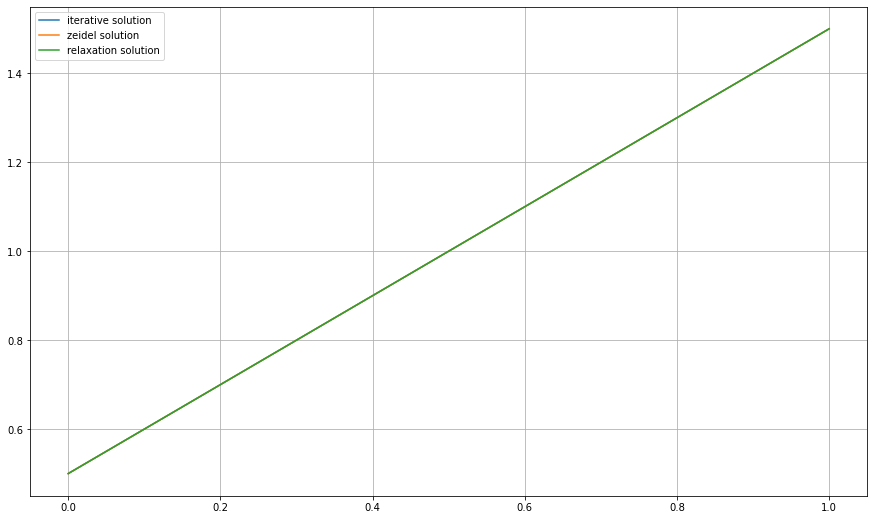

In [19]:
import matplotlib.pyplot as plt

def plot_results(
    iterative_solution,
    zeidel_solution,
    relaxation_solution,
    cur_y,
    x_range,
    y_range,
    h_x,
    h_y,
):
    x = np.arange(*x_range, h_x)
    y = np.arange(*y_range, h_y)
    j = abs(y - cur_y).argmin()

    plt.figure(figsize=(15, 9))
    
    plt.plot(x, iterative_solution[:, j], label='iterative solution')
    plt.plot(x, zeidel_solution[:, j], label='zeidel solution')
    plt.plot(x, relaxation_solution[:, j], label='relaxation solution')

    plt.legend()
    plt.grid()
    plt.show()

plot_results(
    iterative_solution,
    zeidel_solution,
    relaxation_solution,
    0.5,
    (x_begin, x_end),
    (y_begin, y_end),
    h_x,
    h_y
)


Изменение погрешности

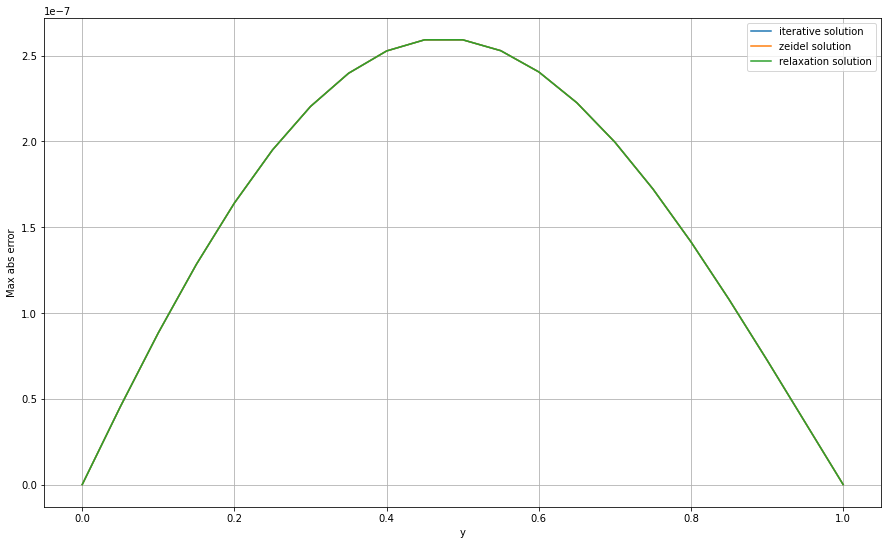

In [20]:
def plot_errors(
    iterative_solution,
    zeidel_solution,
    relaxation_solution,
    analytical_solution,
    y_range,
    h_y,
):
    y = np.arange(*y_range, h_y)

    plt.figure(figsize=(15, 9))
    
    iterative_err = np.array([max_abs_error(iterative_solution[:, i], analytical_solution[:, i]) for i in range(len(y))])
    plt.plot(y, iterative_err, label='iterative solution')

    zeidel_err = np.array([max_abs_error(zeidel_solution[:, i], analytical_solution[:, i]) for i in range(len(y))])
    plt.plot(y, zeidel_err, label='zeidel solution')

    relaxation_err = np.array([max_abs_error(relaxation_solution[:, i], analytical_solution[:, i]) for i in range(len(y))])
    plt.plot(y, relaxation_err, label='relaxation solution')

    plt.xlabel('y')
    plt.ylabel('Max abs error')

    plt.legend()
    plt.grid()
    plt.show()

plot_errors(
    iterative_solution,
    zeidel_solution,
    relaxation_solution,
    analytical_solution,
    (y_begin, y_end),
    h_y
)
